In [12]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%autosave 5

# necessary modules -------------------------------------------------------------------------------------
import socket
import sys
import os
home = os.path.expanduser("~")
from glob import glob as gg
import cmocean as cmo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import xarray as xr
import time
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
import seaborn as sns

Autosaving every 5 seconds


In [13]:
##############################################

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('axes', linewidth=2)
plt.rc('axes', grid=False)
plt.rc('axes', edgecolor='black')

plt.rc('ytick.major', size = 2)
plt.rc('ytick.major', width = 2)
plt.rc('xtick.minor', visible = True)
plt.rc('xtick.major', size = 2)
plt.rc('xtick.minor', size = 1)
plt.rc('xtick.major', width = 2)
plt.rc('xtick.minor', width = 1)

plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('pdf', fonttype = 42)

palette = sns.color_palette("Spectral", n_colors = 6)

#################################################

In [15]:
# load model data
data_path = home+'/Documents/projects/nuarctic/NuArctic/nuarctic/REcoM1D/results/'
output_file = 'REcoM1d_outputs.nc'
diag_file = 'REcoM1d_diagnostics.nc'
outputs = xr.open_dataset(data_path+output_file)
diags = xr.open_dataset(data_path+diag_file)
dates = pd.to_datetime(outputs['year'].data * 1000 + outputs['day'].data, format='%Y%j')

In [19]:
# load Chl-a in situ data
obs_path = home+'/Documents/projects/nuarctic/NuArctic/nuarctic/'
df_chla = pd.read_excel(obs_path+'data/CHLA/MOSAiC_Chla_forLaurent_20220905.xlsx')

In [23]:
# load Nutrients in situ data
obs_path = home+'/Documents/projects/nuarctic/NuArctic/nuarctic/'
df_nut = pd.read_csv(obs_path+'data/NUTRIENTS/06AQ20190920.csv', header = 14, na_values=-999, encoding='latin-1')
df_nut['time'] = pd.to_datetime((df_nut['DATE']), format='%Y%m%d')

In [24]:
# load CTD Polarstern
filename_CTD_data = obs_path+'CTD_Rosette/Polarstern/PS122_*_Polarstern.txt'

files = gg(filename_CTD_data, recursive = True)
files = np.sort(files)

for i in np.arange(0,len(files)):
    print(files[i])
    df_temp = pd.read_csv(files[i], index_col = 'Date/Time', sep="\t", parse_dates=['Date/Time'])
    
    if i==0:
        df = df_temp
    else:
        df = pd.concat([df, df_temp])

In [82]:
# load UVP-POC in situ data

#dataset0
# df_uvp = pd.read_csv(obs_path+'data/UVP/MOSAIC_C_pred_consolidated.csv')
# df_uvp['Date'] = pd.to_datetime(df_uvp['Date'], format = '%Y-%m-%d')



#dataset1
df_uvp = pd.read_csv(obs_path+'data/UVP/MOSAIC_POC_pred_fieldmeas_UVP_only.tsv', sep = '\t') #, index_col = 'datetime', delim_whitespace=True, date_parser=True
#df_uvp = df_uvp.set_index('datetime')
#df_uvp['datetime'] = df_uvp['datetime'].dt.date
#df_uvp['datetime'] = pd.to_datetime(df_uvp['datetime'], format = '%Y-%m-%d %H:%M:%S.%f')
df_uvp


# df_uvp['C_>100_µm_predicted_[µg_L-1]'][df_uvp['C_>100_µm_predicted_[µg_L-1]']<= 10] = np.nan
# df_uvp_notnan = df_uvp[df_uvp['C_>100_µm_predicted_[µg_L-1]'].notna()]
# df_uvp_notnan['Date'] = pd.to_datetime(df_uvp_notnan['Date'], format = '%Y-%m-%d')

,ctd_station,depth_[m],lpm_biovolume_(102-128_µm)_[mm3_l-1],lpm_biovolume_(128-161_µm)_[mm3_l-1],lpm_biovolume_(161-203_µm)_[mm3_l-1],lpm_biovolume_(203-256_µm)_[mm3_l-1],lpm_biovolume_(256-323_µm)_[mm3_l-1],lpm_biovolume_(323-406_µm)_[mm3_l-1],lpm_biovolume_(406-512_µm)_[mm3_l-1],lpm_biovolume_(512-645_µm)_[mm3_l-1],...,lpm_biovolume_(0.813-1.02_mm)_[mm3_l-1],lpm_biovolume_(1.02-1.29_mm)_[mm3_l-1],lpm_biovolume_(1.29-1.63_mm)_[mm3_l-1],lpm_biovolume_(1.63-2.05_mm)_[mm3_l-1],lpm_biovolume_2-6,lpm_biovolume_6-26,latitude,longitude,poc_pred_[mg_m-3],datetime
0,ps122_1_2_68,2.5,0.021406,0.022229,0.049502,0.047119,0.032564,0.010924,0.002611,0.004286,...,0.005429,0.026242,0.017716,0.069372,0.116237,0.0,85.12810,132.55192,27.019026,2019-10-04 08:28:19
1,ps122_4_45_76,2.5,0.035340,0.028553,0.053747,0.059824,0.065643,0.078694,0.106095,0.126787,...,0.139383,0.093546,0.093796,0.166993,0.489036,0.0,81.67745,7.36830,58.619260,2020-07-03 14:48:30
2,ps122_3_31_59,2.5,0.002323,0.001513,0.003205,0.002559,0.003123,0.003680,0.001710,0.000000,...,0.002225,0.003828,0.000000,0.000000,0.000000,0.0,87.14817,17.42905,16.875556,2020-03-14 06:57:20
3,ps122_2_19_56,2.5,0.001788,0.000742,0.001324,0.001106,0.000400,0.000224,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,87.13832,114.47635,16.525484,2020-01-09 07:47:28
4,ps122_4_49_36,2.5,0.052796,0.049639,0.115050,0.116044,0.093982,0.042125,0.029588,0.021025,...,0.028727,0.032932,0.084481,0.013535,0.000000,0.0,79.11632,-2.54002,49.321457,2020-07-30 06:36:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25771,ps122_2_23_47,4452.5,0.009540,0.008676,0.011011,0.006207,0.005194,0.009670,0.006062,0.011731,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,87.60075,94.04537,0.000000,2020-02-06 07:58:43
25772,ps122_2_21_65c,4452.5,0.012585,0.009203,0.017729,0.016415,0.012634,0.008069,0.003405,0.004437,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,87.44658,94.08855,0.000000,2020-01-23 08:28:24
25773,ps122_2_22_47b,4457.5,0.008793,0.006213,0.011338,0.008659,0.006952,0.002000,0.002411,0.001814,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,87.47410,96.35725,0.000000,2020-01-30 08:09:52
25774,ps122_2_21_65c,4457.5,0.012436,0.009073,0.016328,0.013640,0.013451,0.011068,0.003554,0.000569,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,87.44658,94.08855,0.000000,2020-01-23 08:28:24


In [50]:
# re-constitute datetime index from Andreas Rogge file

# datetime_list = []

# for index, row in df_uvp.iterrows():
#     tmp = row['ctd_station']
#     tmp_1 = tmp[2:5]
#     tmp_2 = tmp[6:9]
#     tmp_3 = tmp[10:]

#     tag = 'PS'+str(tmp_1)+'/'+str(tmp_2)+'-'+str(tmp_3)
#     idx = df.index[df['Event Label'] == tag].to_list()
    
#     if np.any(idx):
#         datetime_list.append(pd.to_datetime(idx[0]))
#     else:
#         tmp_1 = tmp[2:5]
#         tmp_2 = tmp[6:10]
#         tmp_3 = tmp[11:]
#         tag = 'PS'+str(tmp_1)+'/'+str(tmp_2)+'-'+str(tmp_3)
#         idx = df.index[df['Event Label'] == tag].to_list()
        
#         if np.any(idx):
#             datetime_list.append(pd.to_datetime(idx[0]))
#         else:
#             tmp_1 = tmp[2:5]
#             tmp_2 = tmp[6:10]
#             tmp_3 = tmp[11:13]
#             tag = 'PS'+str(tmp_1)+'/'+str(tmp_2)+'-'+str(tmp_3)
#             idx = df.index[df['Event Label'] == tag].to_list()
#             if np.any(idx):
#                 datetime_list.append(pd.to_datetime(idx[0]))
#             else:
#                 print('STILL NO DATE FOUND !!!!!!!')
        
# new_datetime_index = pd.DatetimeIndex(datetime_list)
# df_uvp['Date'] = new_datetime_index
# df_uvp.set_index('Date', inplace=True)
# df_uvp.to_csv(obs_path+'UVP/MOSAIC_C_pred_consolidated.csv')

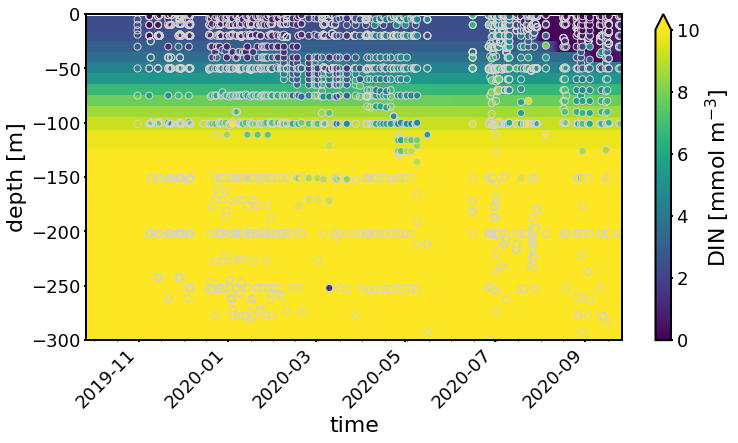

In [27]:
fig, ax = plt.subplots(figsize = (12,6))

pc = ax.pcolor(dates, outputs['z_cell'].data, outputs['DIN'].data, 
               vmin=0, vmax=10)
ax.set_ylim(-300,0)
ax.set_xlim([datetime.date(2019, 9, 26), datetime.date(2020, 9, 26)])

ax.scatter(df_nut['time'], -df_nut['CTDPRS'], 50, df_nut['NITRAT'], edgecolors= 'lightgray',
          vmin=0, vmax=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('time')
ax.set_ylabel('depth [m]')

cbar = fig.colorbar(pc, ax = ax, extend='max')
cbar.set_label('DIN [mmol m$^{-3}$]')

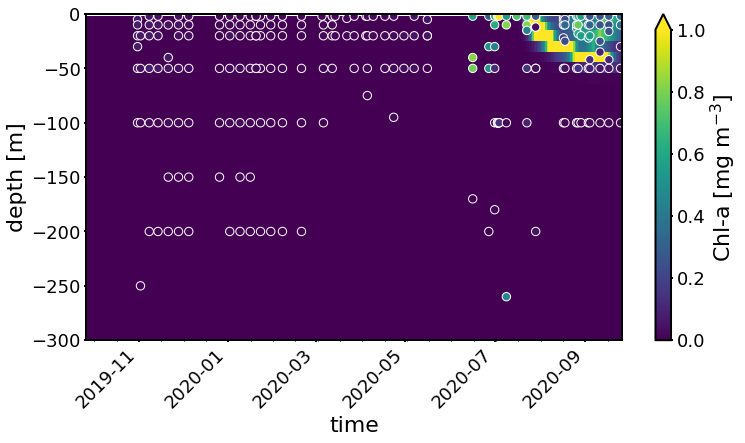

In [28]:
fig, ax = plt.subplots(figsize = (12,6))

pc = ax.pcolor(dates, outputs['z_cell'].data, outputs['DiaChl'].data+outputs['PhyChl'].data, 
               vmin=0, vmax=1)
ax.set_ylim(-300,0)
ax.set_xlim([datetime.date(2019, 9, 26), datetime.date(2020, 9, 26)])

ax.scatter(df_chla['Date'], -df_chla['desired_depth'], 70, df_chla['Chl[µg L-1]'], edgecolors= 'w',
          vmin=0, vmax=1)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('time')
ax.set_ylabel('depth [m]')

cbar = fig.colorbar(pc, ax = ax, extend='max')
cbar.set_label('Chl-a [mg m$^{-3}$]')

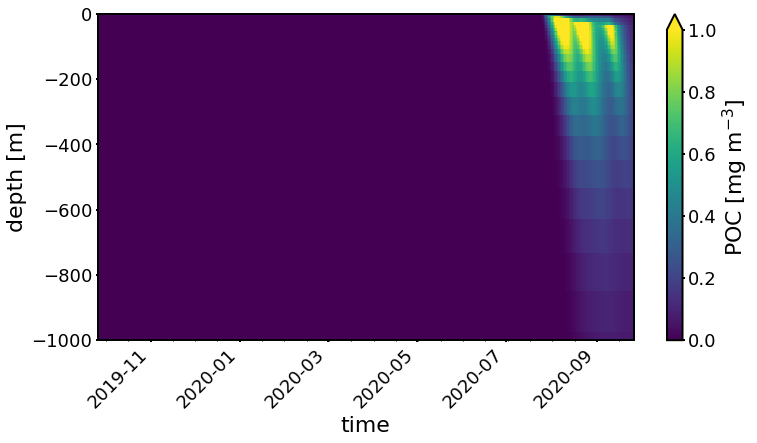

In [87]:
fig, ax = plt.subplots(figsize = (12,6))
vmin = 0
vmax = 1

pc = ax.pcolor(dates, outputs['z_cell'].data, (outputs['DetC'].data+outputs['idetz2c'].data), 
               vmin=vmin, vmax=vmax)
ax.set_ylim(-1000,0)
ax.set_xlim([datetime.date(2019, 9, 26), datetime.date(2020, 9, 26)])

# ax.scatter(df_uvp['datetime'], -df_uvp['depth_[m]'], 40, (df_uvp['poc_pred_[mg_m-3]']),
#            edgecolors= None,
#           vmin=vmin, vmax=vmax)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('time')
ax.set_ylabel('depth [m]')

cbar = fig.colorbar(pc, ax = ax, extend='max')
cbar.set_label('POC [mg m$^{-3}$]')

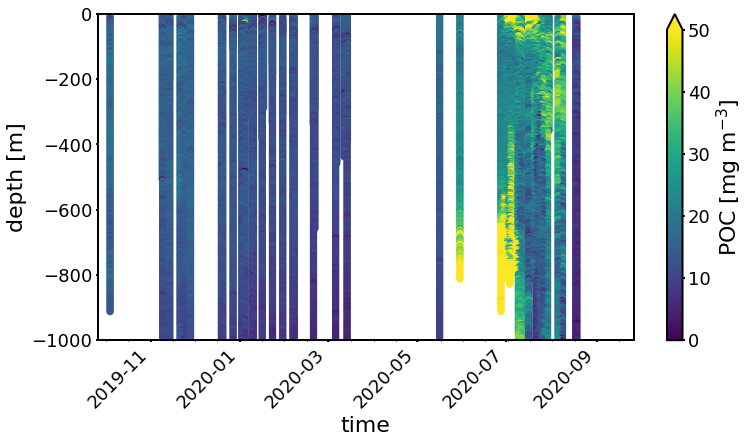

In [98]:
fig, ax = plt.subplots(figsize = (12,6))
vmin = 0
vmax = 50

# pc = ax.pcolor(dates, outputs['z_cell'].data, (outputs['DetC'].data+outputs['idetz2c'].data), 
#                vmin=vmin, vmax=vmax)
ax.set_ylim(-1000,0)
ax.set_xlim([datetime.date(2019, 9, 26), datetime.date(2020, 9, 26)])

pc = ax.scatter(df_uvp['datetime'], -df_uvp['depth_[m]'], 40, (df_uvp['poc_pred_[mg_m-3]']),
           edgecolors= None,
          vmin=vmin, vmax=vmax)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('time')
ax.set_ylabel('depth [m]')

cbar = fig.colorbar(pc, ax = ax, extend='max')
cbar.set_label('POC [mg m$^{-3}$]')

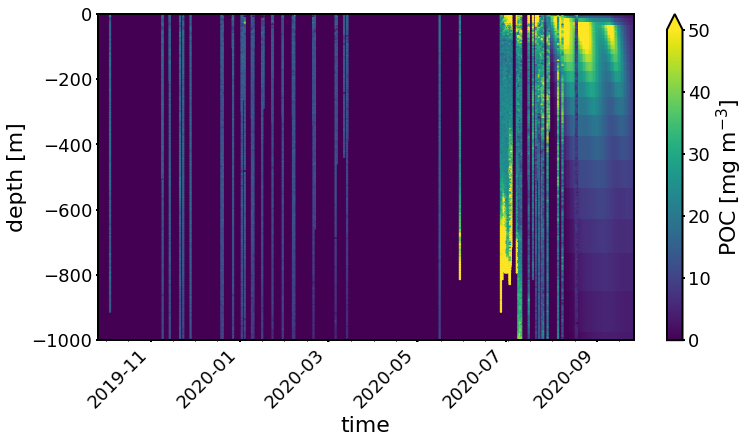

In [101]:
fig, ax = plt.subplots(figsize = (12,6))
vmin = 0
vmax = 50

pc = ax.pcolor(dates, outputs['z_cell'].data, 50*(outputs['DetC'].data+outputs['idetz2c'].data), 
               vmin=vmin, vmax=vmax)
ax.set_ylim(-1000,0)
ax.set_xlim([datetime.date(2019, 9, 26), datetime.date(2020, 9, 26)])

ax.scatter(df_uvp['datetime'], -df_uvp['depth_[m]'], 2, (df_uvp['poc_pred_[mg_m-3]']),
           edgecolors= None,
          vmin=vmin, vmax=vmax)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('time')
ax.set_ylabel('depth [m]')

cbar = fig.colorbar(pc, ax = ax, extend='max')
cbar.set_label('POC [mg m$^{-3}$]')

In [24]:
df_uvp

,Date,ctd_station,longitude,latitude,depth_[m],lpm_biovolume_(102-128_µm)_[mm3_l-1],lpm_biovolume_(128-161_µm)_[mm3_l-1],lpm_biovolume_(161-203_µm)_[mm3_l-1],lpm_biovolume_(203-256_µm)_[mm3_l-1],lpm_biovolume_(256-323_µm)_[mm3_l-1],...,lpm_biovolume_(4.1-5.16_mm)_[mm3_l-1],lpm_biovolume_(5.16-6.5_mm)_[mm3_l-1],lpm_biovolume_(6.5-8.19_mm)_[mm3_l-1],lpm_biovolume_(8.19-10.3_mm)_[mm3_l-1],lpm_biovolume_(10.3-13_mm)_[mm3_l-1],lpm_biovolume_(13-16.4_mm)_[mm3_l-1],lpm_biovolume_(16.4-20.6_mm)_[mm3_l-1],lpm_biovolume_(20.6-26_mm)_[mm3_l-1],lpm_biovolume_(>26_mm)_[mm3_l-1],C_>100_µm_predicted_[µg_L-1]
0,2019-10-04 08:25:45,ps122_1_2_68,132.55192,85.12810,2.5,0.021406,0.022229,0.049502,0.047119,0.032564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.912068
1,2019-10-04 08:25:45,ps122_1_2_68,132.55192,85.12810,7.5,0.008911,0.008390,0.019820,0.020685,0.015772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.500084
2,2019-10-04 08:25:45,ps122_1_2_68,132.55192,85.12810,12.5,0.002536,0.002543,0.005917,0.006902,0.005889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.951609
3,2019-10-04 08:25:45,ps122_1_2_68,132.55192,85.12810,17.5,0.001628,0.001577,0.003673,0.006219,0.005039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.149217
4,2019-10-04 08:25:45,ps122_1_2_68,132.55192,85.12810,22.5,0.001529,0.001405,0.004077,0.006558,0.005916,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.111256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25771,2020-08-18 06:20:52,ps122_5_59_72,-35.68865,88.93762,992.5,0.003547,0.002417,0.003993,0.003026,0.005614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.970171
25772,2020-08-18 06:20:52,ps122_5_59_72,-35.68865,88.93762,997.5,0.003687,0.002200,0.003870,0.002722,0.004118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.968294
25773,2020-08-18 06:20:52,ps122_5_59_72,-35.68865,88.93762,1002.5,0.003519,0.002294,0.003568,0.003100,0.003800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.081711
25774,2020-08-18 06:20:52,ps122_5_59_72,-35.68865,88.93762,1007.5,0.003466,0.002181,0.003441,0.002808,0.003431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.944885


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

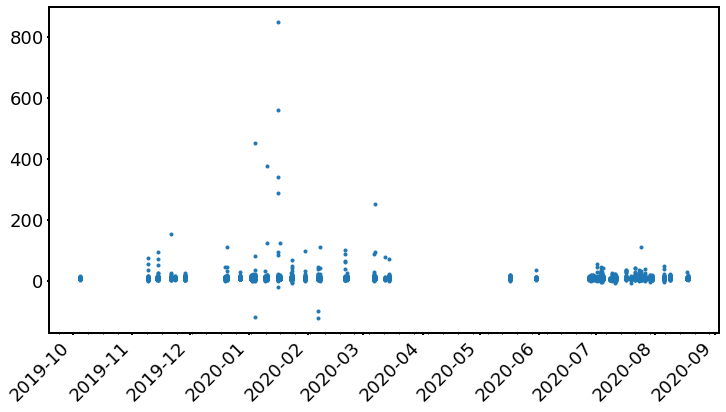

In [33]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(df_uvp['Date'].values, df_uvp['C_>100_µm_predicted_[µg_L-1]'],'.')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

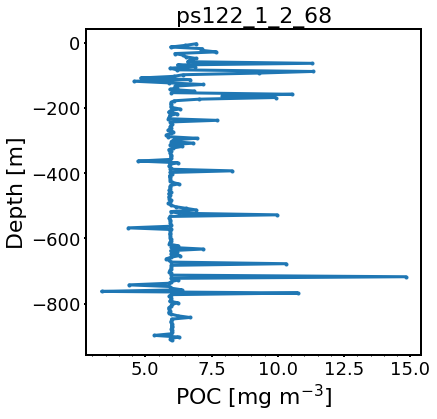

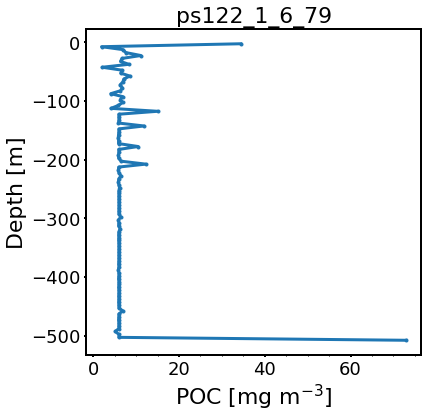

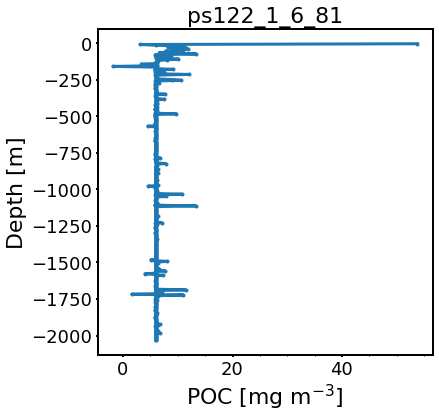

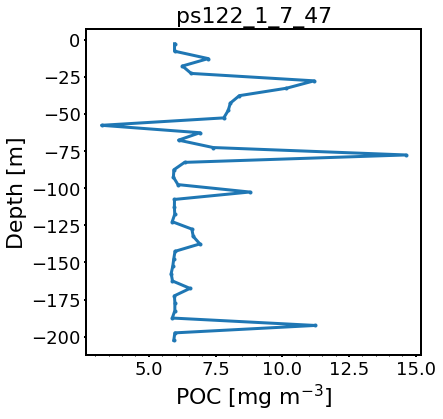

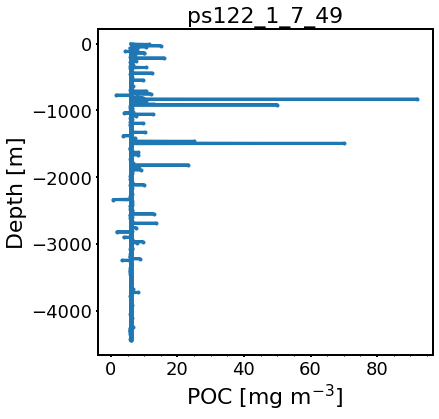

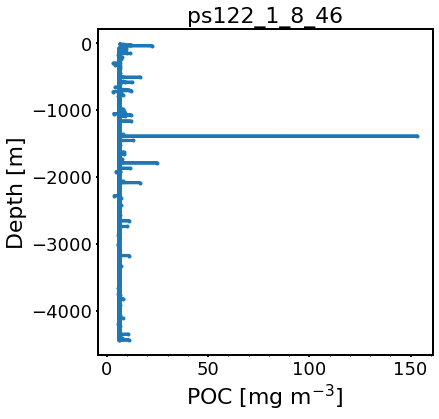

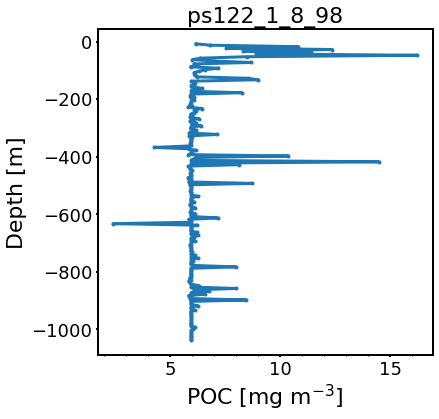

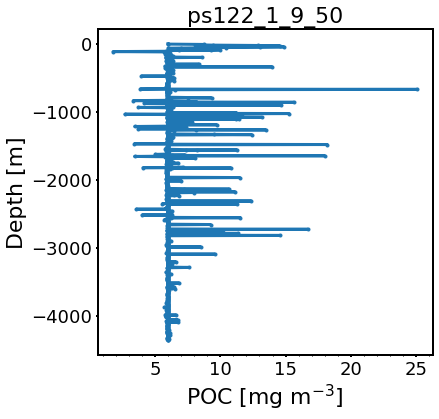

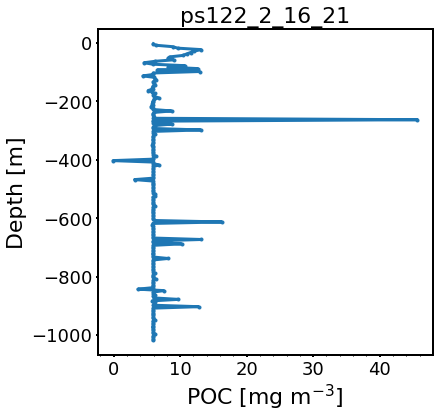

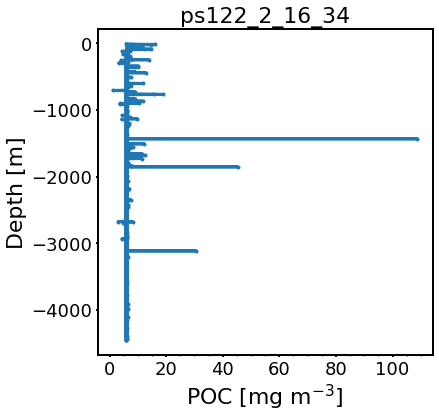

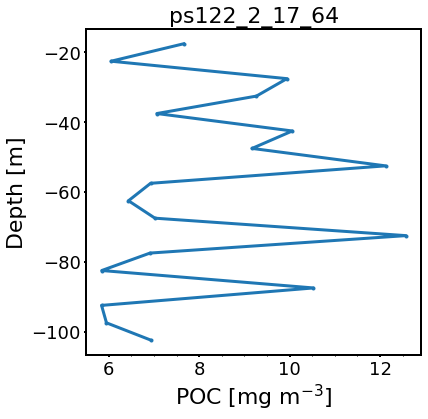

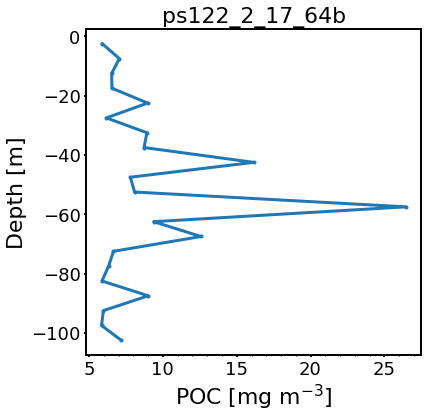

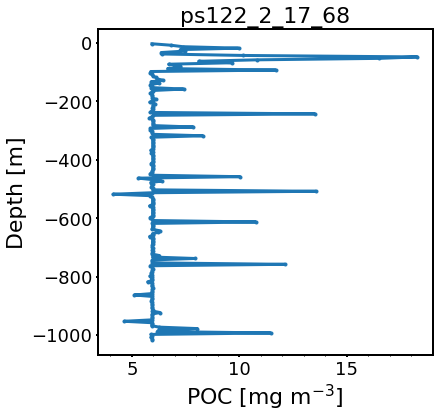

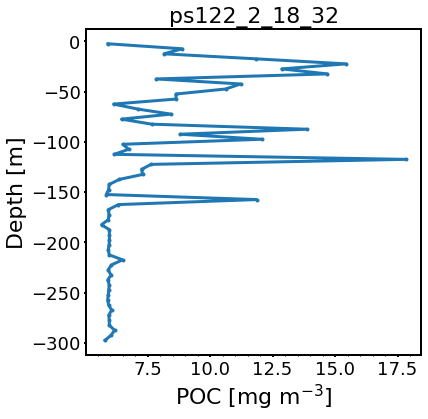

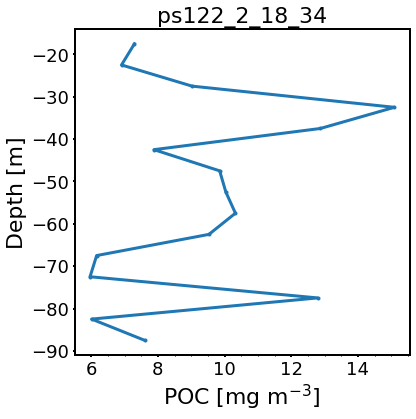

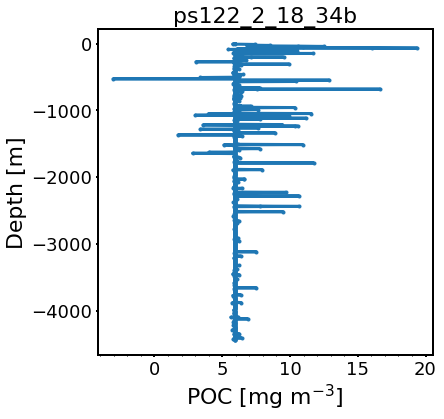

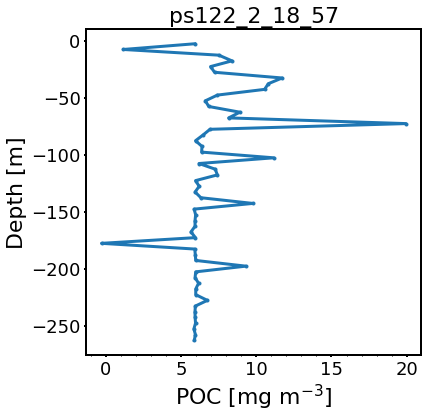

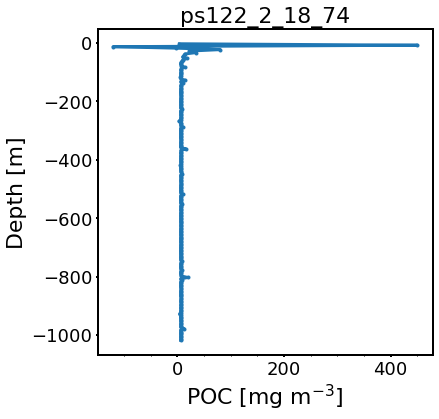

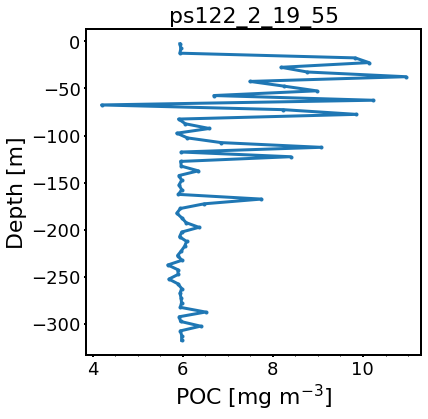

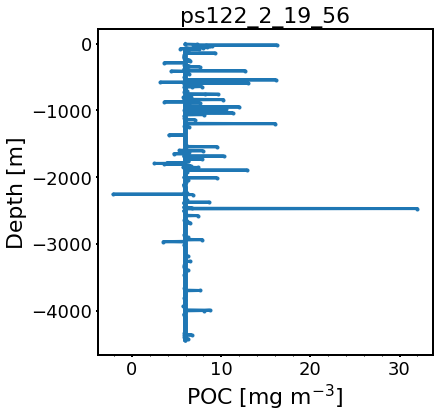

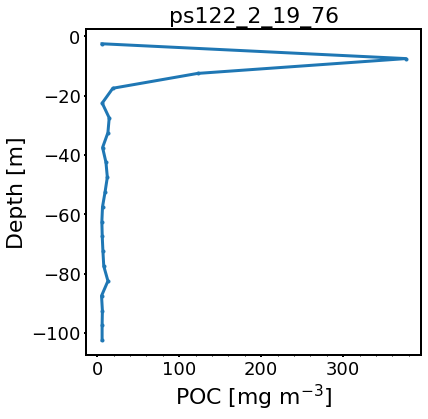

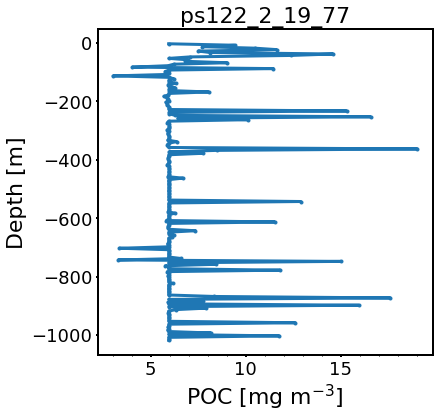

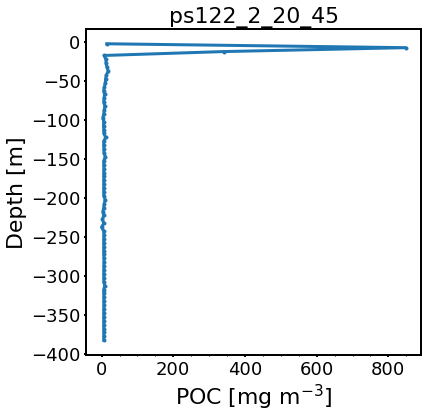

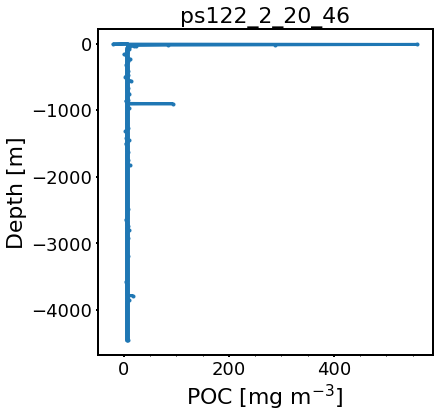

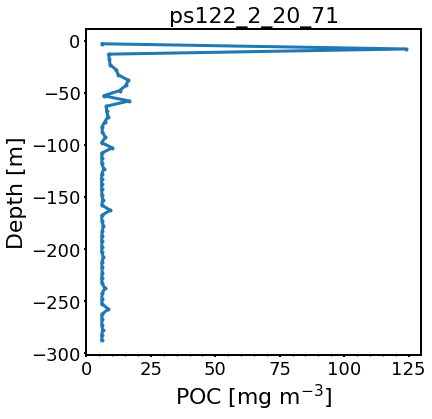

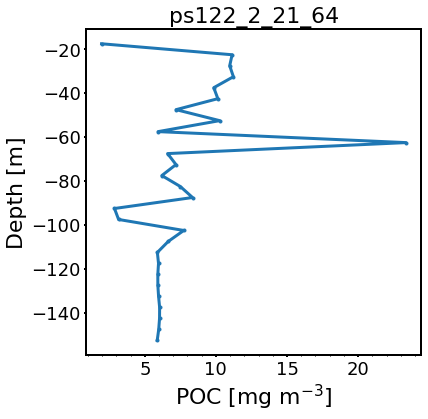

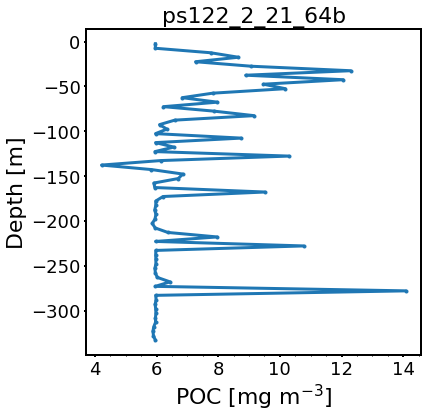

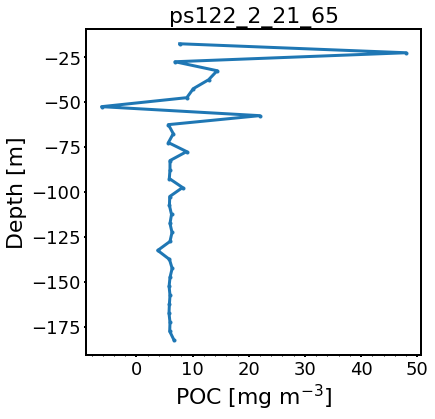

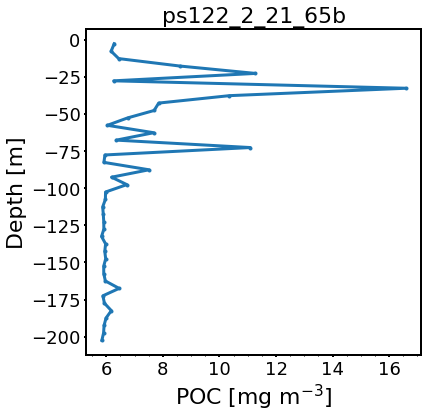

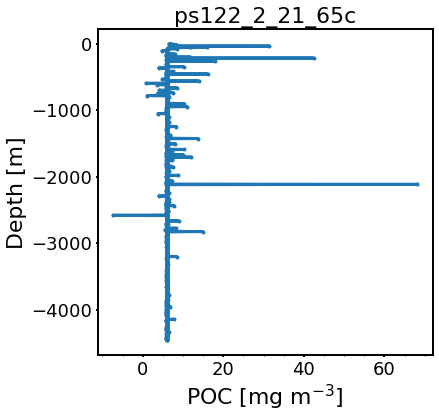

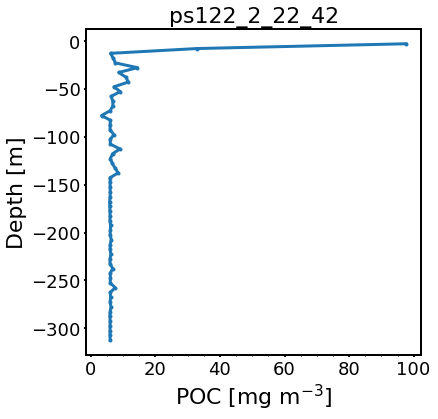

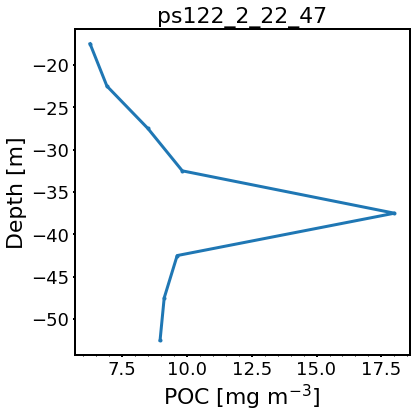

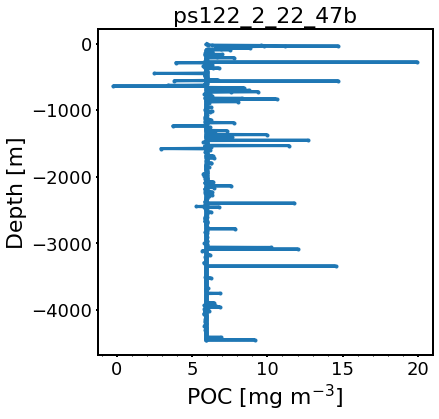

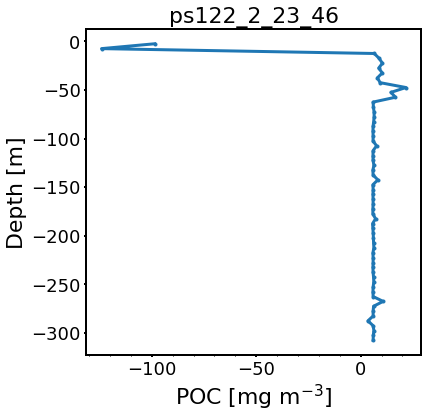

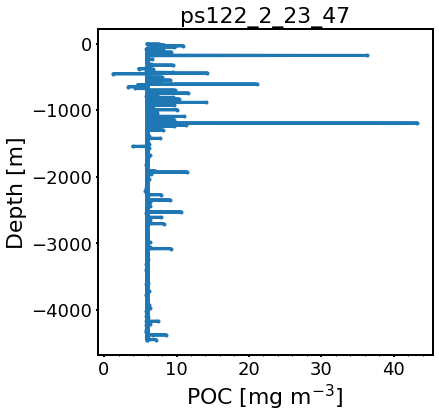

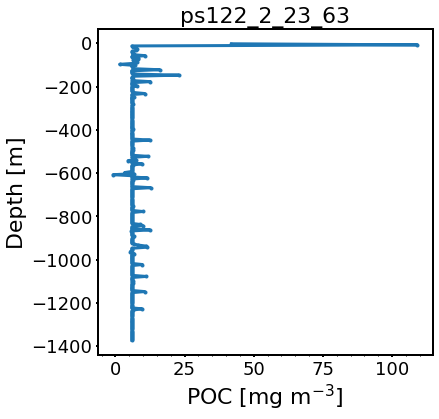

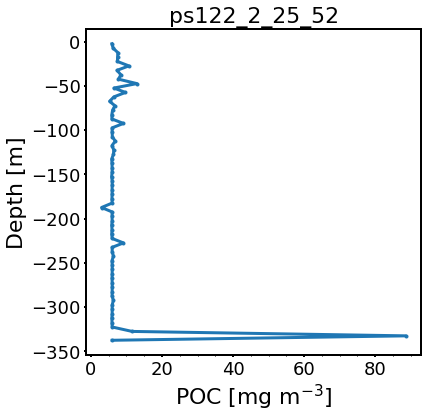

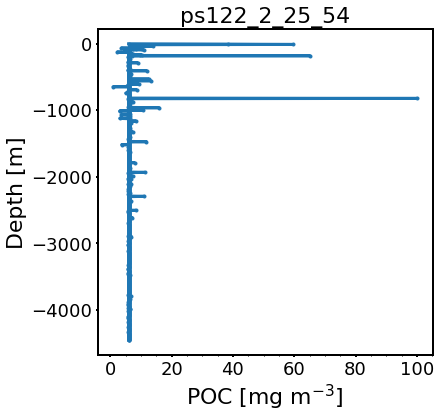

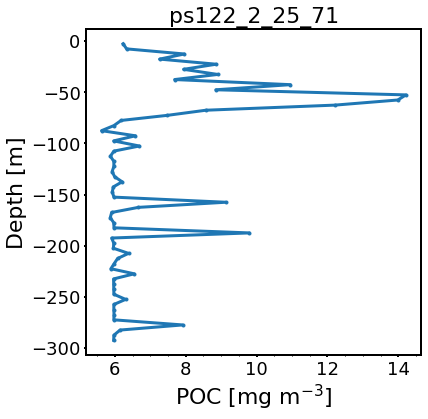

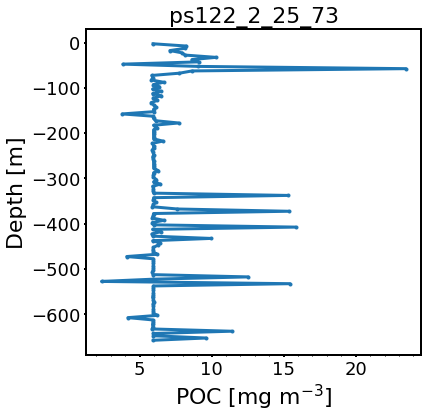

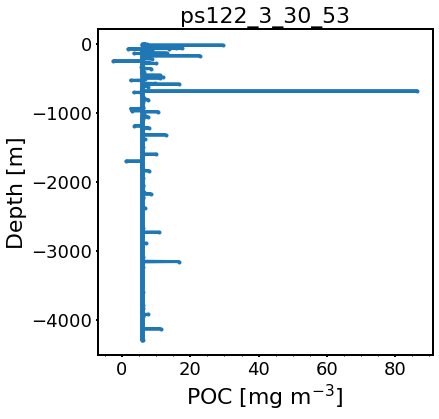

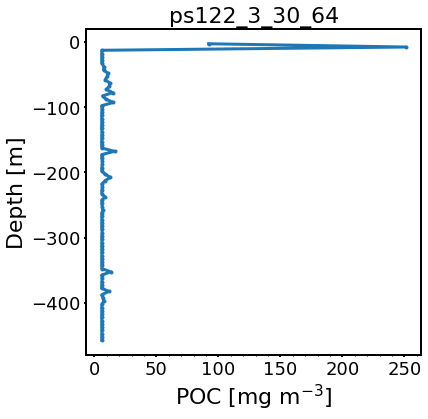

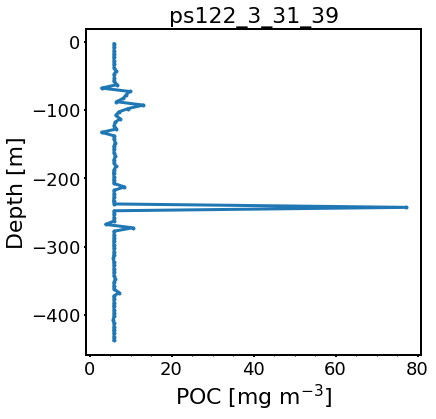

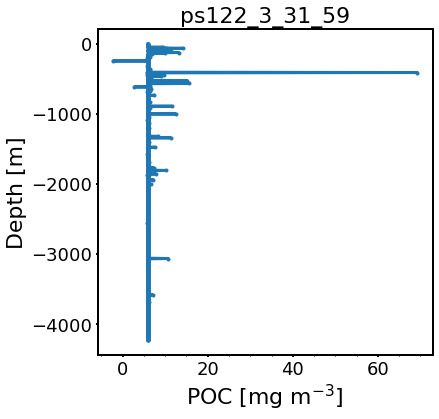

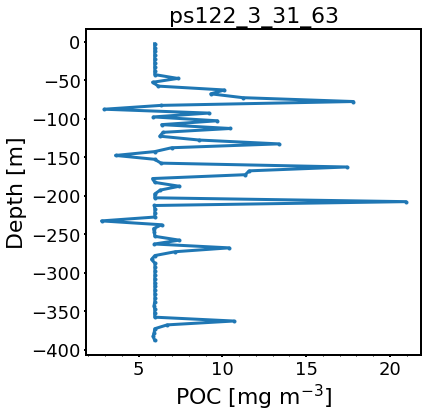

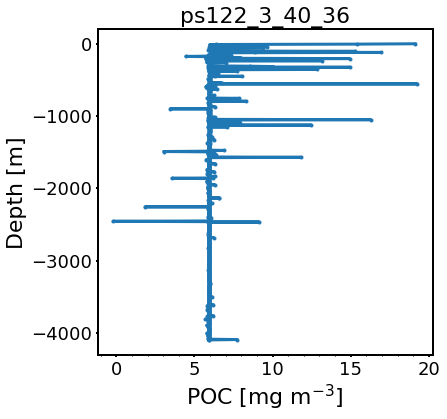

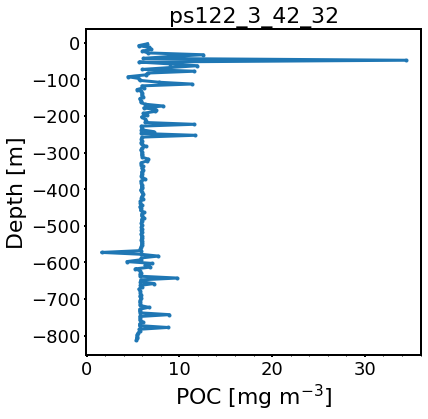

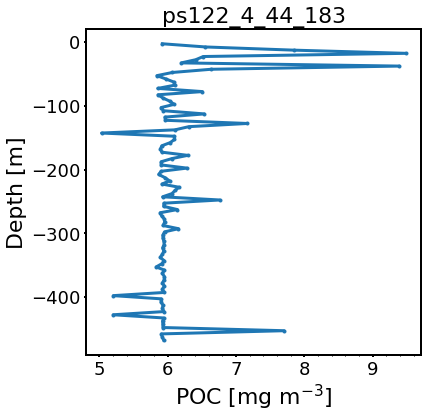

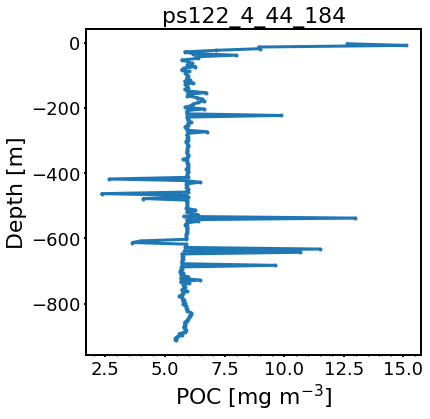

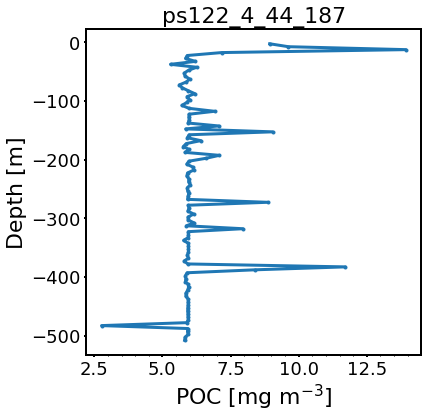

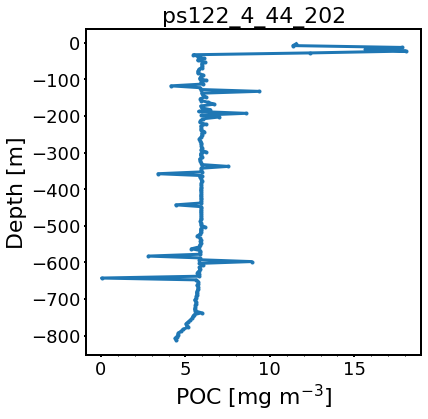

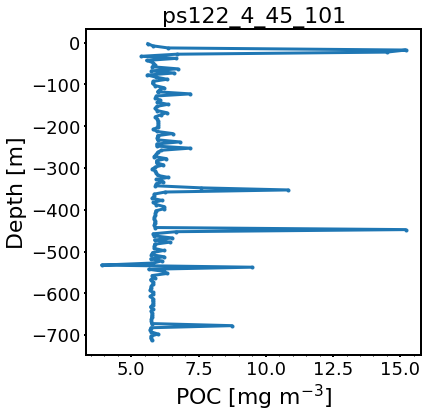

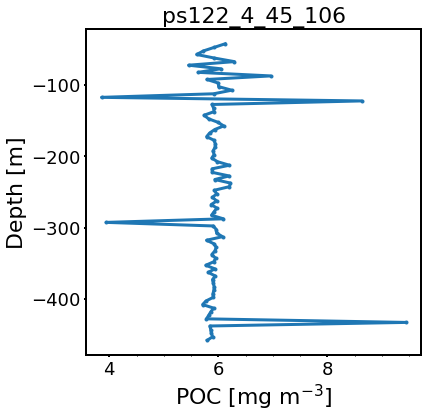

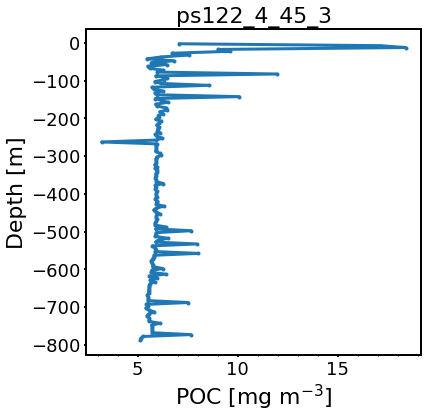

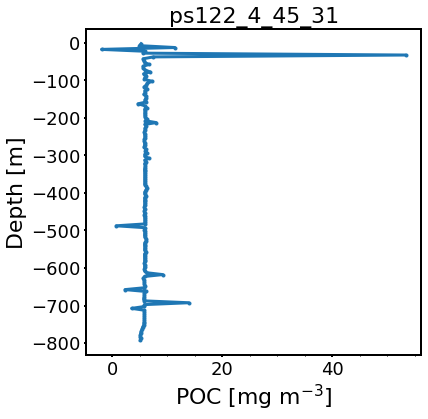

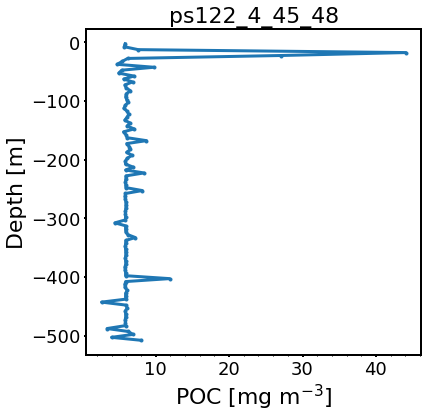

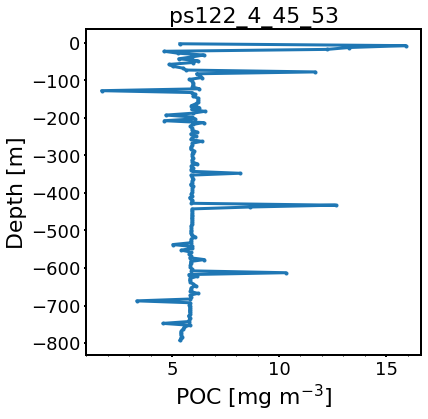

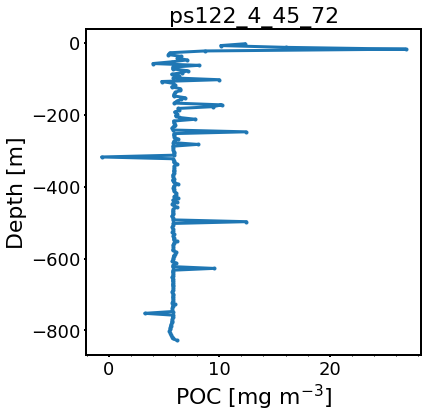

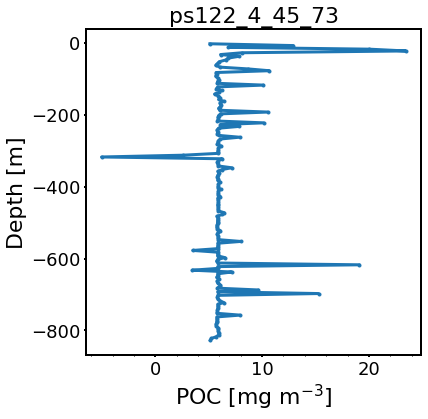

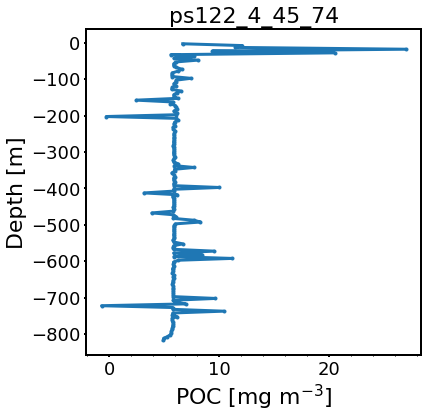

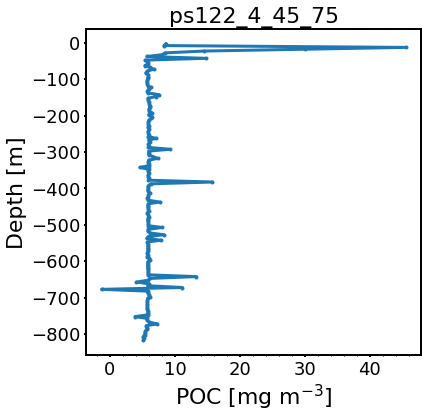

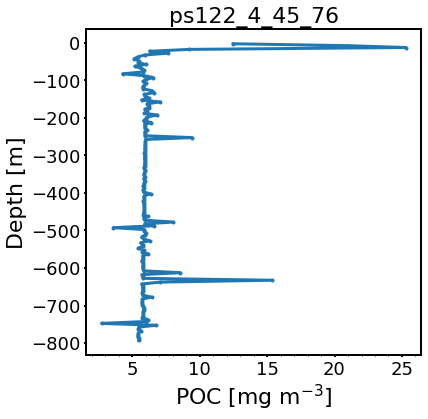

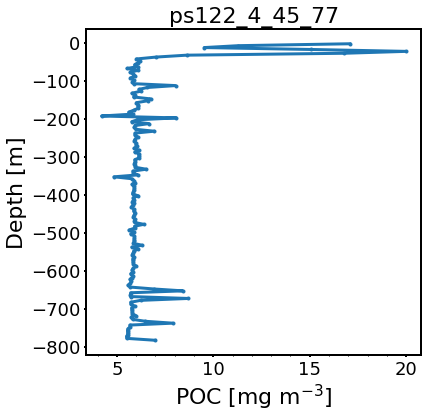

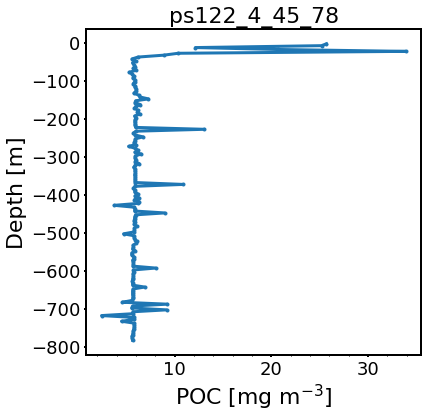

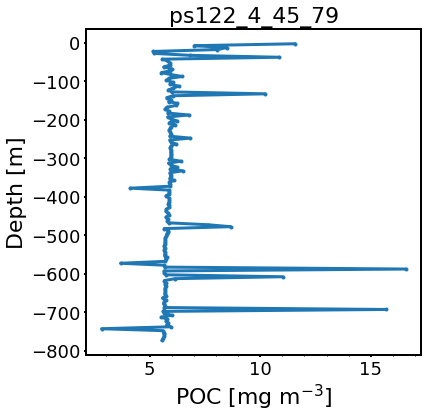

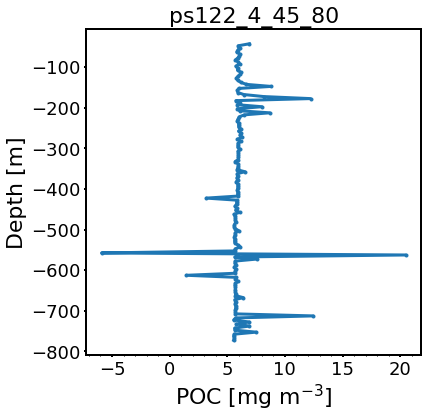

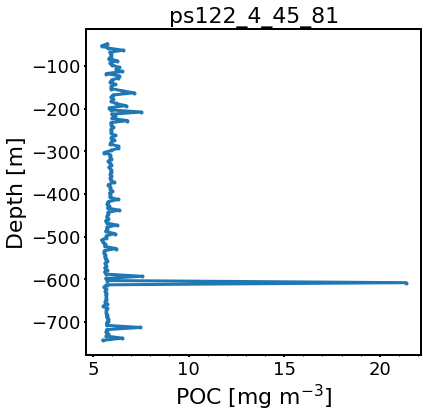

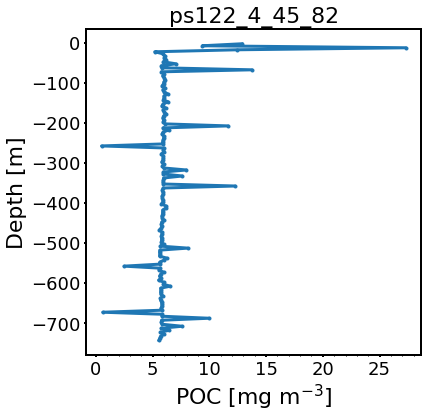

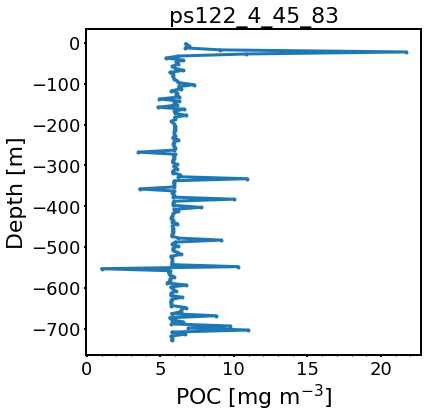

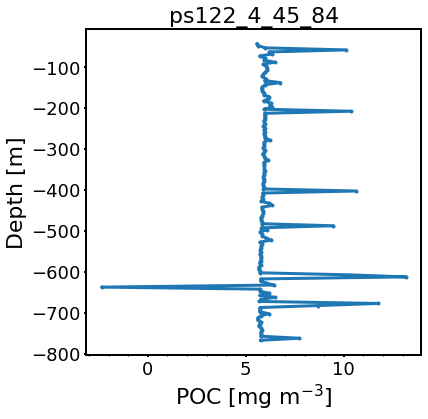

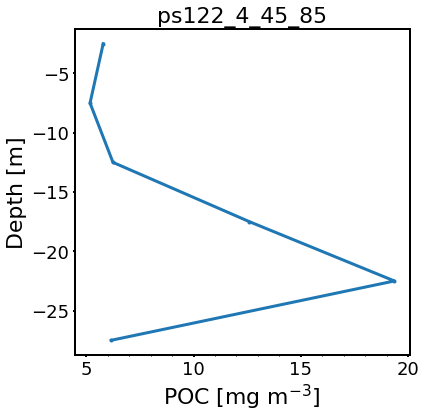

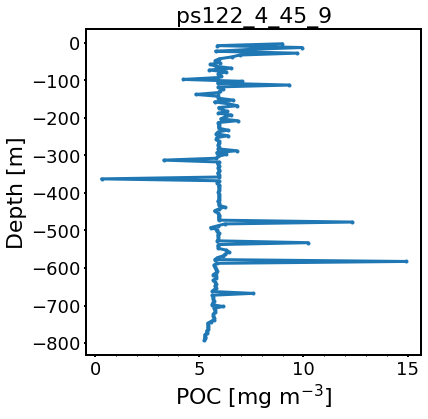

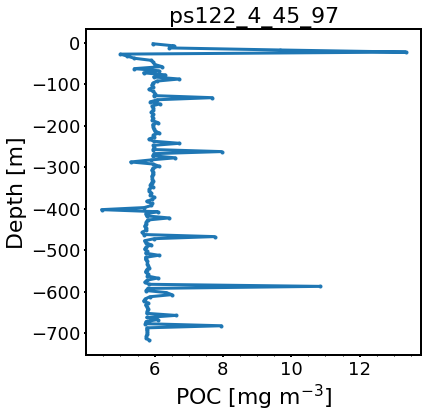

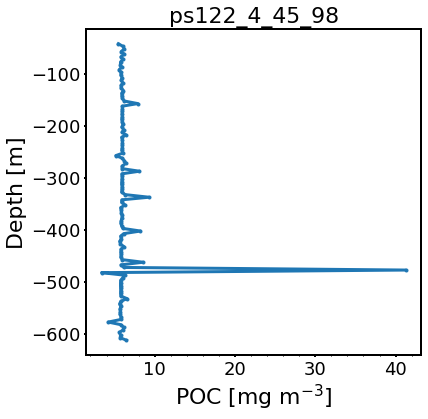

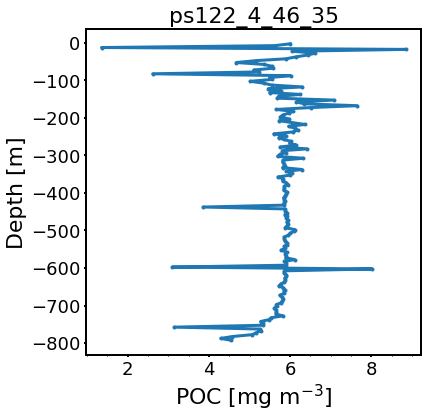

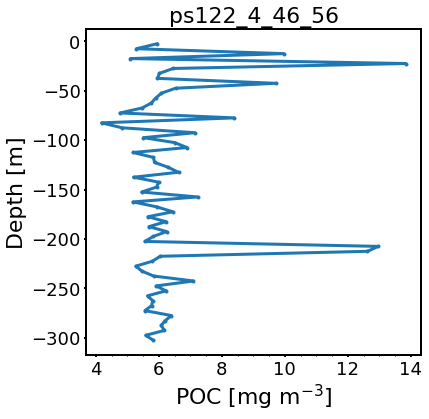

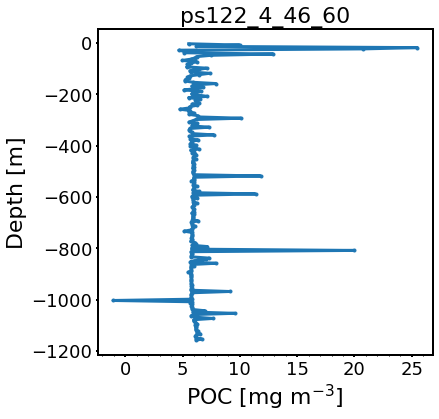

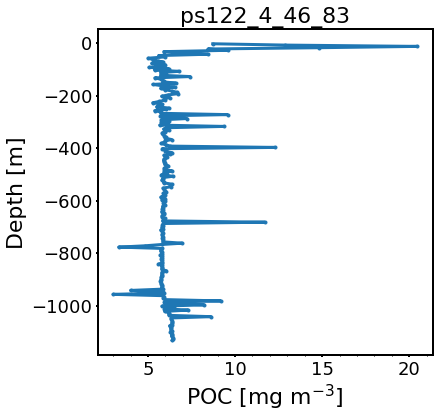

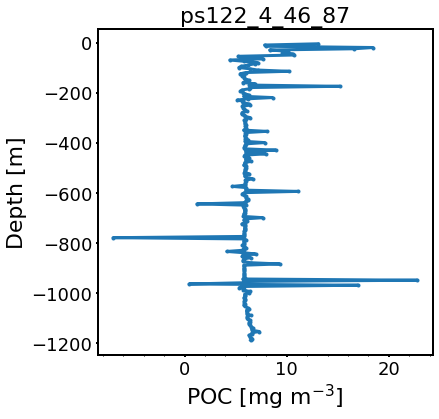

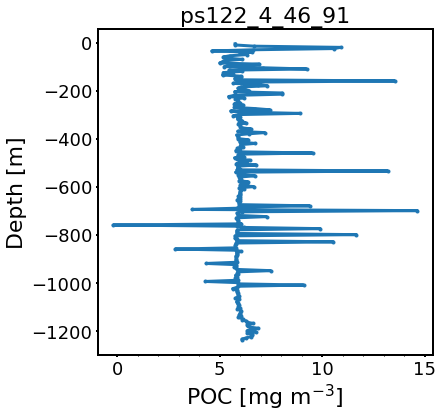

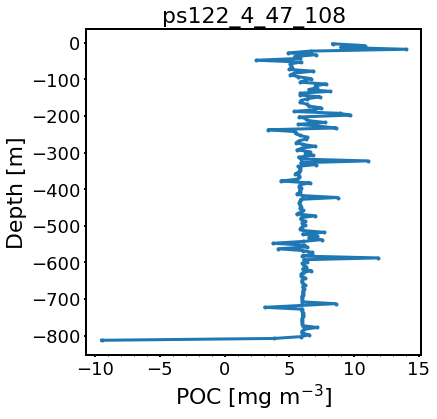

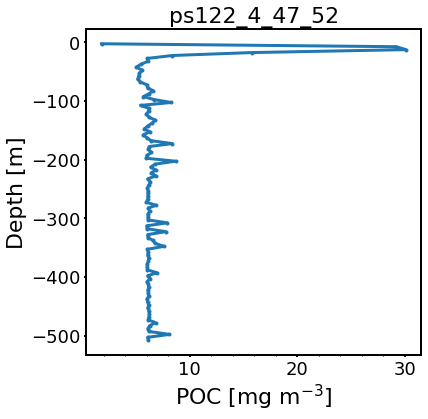

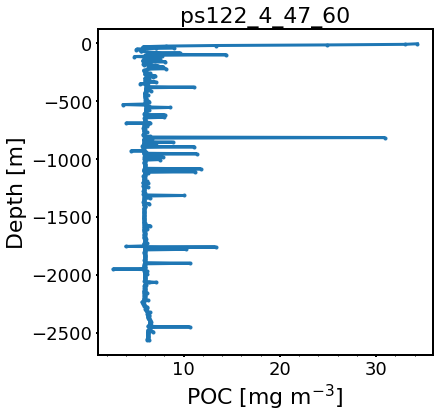

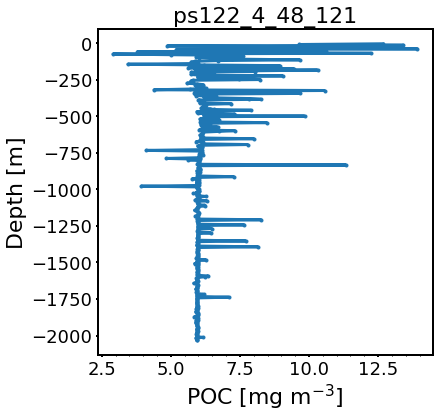

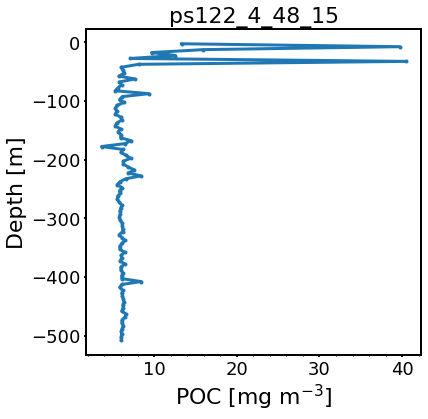

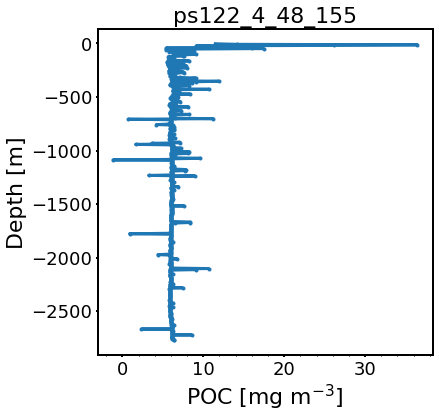

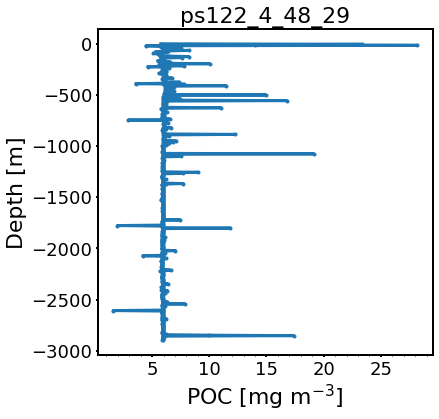

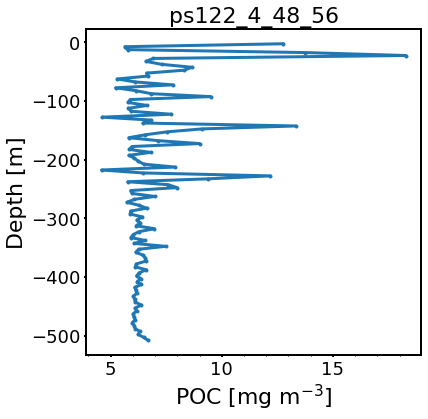

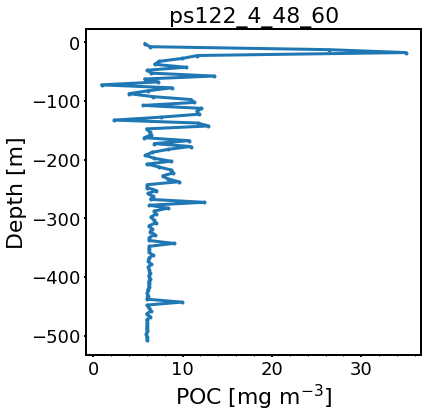

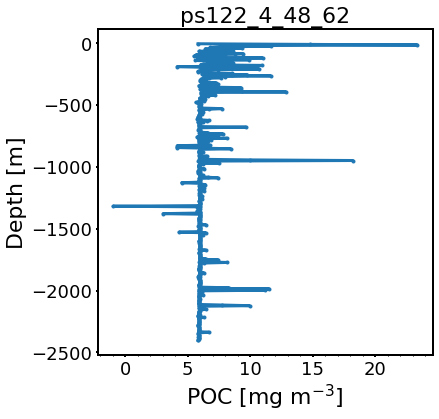

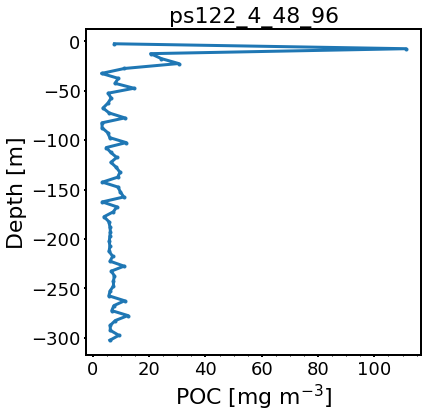

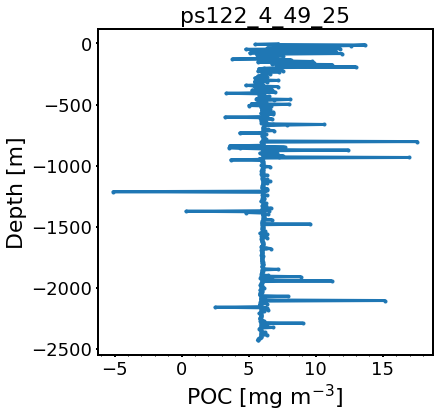

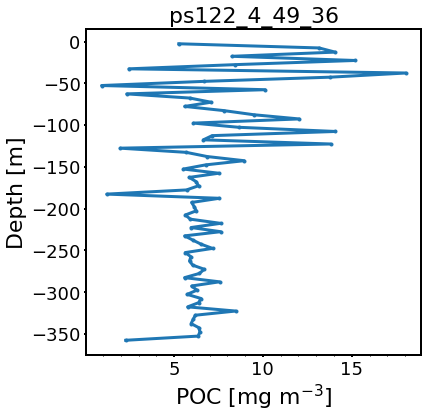

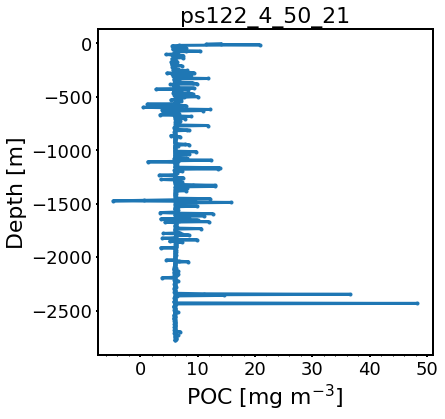

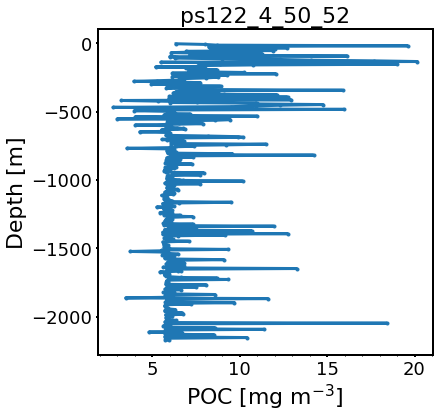

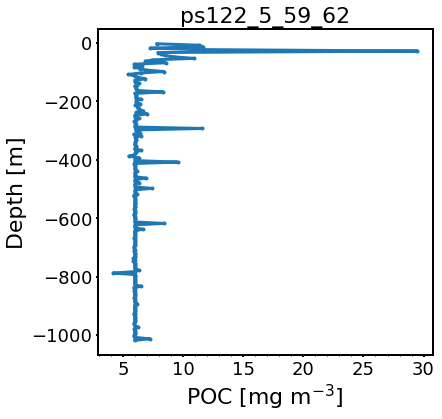

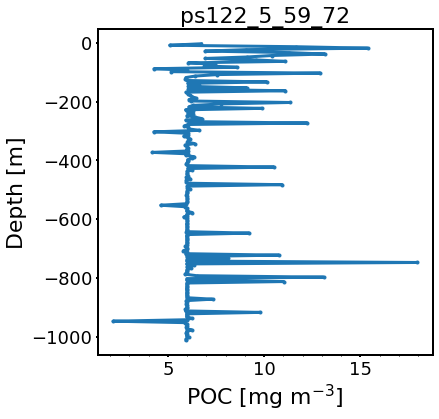

In [15]:
station_list = np.unique(df_uvp['ctd_station'])

for station in station_list:
    #print(station)
    idx = df_uvp.index[df_uvp['ctd_station'] == station].to_list()
    fig, ax = plt.subplots(figsize = (6,6))
    ax.plot(df_uvp['C_>100_µm_predicted_[µg_L-1]'][idx],-df_uvp['depth_[m]'][idx],'.-',lw=3)
    ax.set_title(station)
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('POC [mg m$^{-3}$]')